In [134]:
import mediapipe as mp
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("dark_background")

## Data Loading

In [135]:
data_path = "../../data/sample_videos/sample6.mp4"
_, vid_file_name = os.path.split(data_path)
video = cv2.VideoCapture(data_path)


## Video Processing

In [136]:
def get_centroid_details(file_path):
    """This function gets pose details from mediapipe

    Args:
        file_path (string): This is the path of the video file
        visualize (bool, optional): Provides a visualization for the pose tracking. Defaults to False.

    Returns:
        dict: This dictionary contains a list of upper body pose estimates
    """
    cap = cv2.VideoCapture(file_path)
    mp_pose = mp.solutions.pose

    rh_centroid_x = ()
    rh_centroid_y = ()

    lh_centroid_x = ()
    lh_centroid_y = ()

    with mp_pose.Pose(
        min_detection_confidence=0.5, min_tracking_confidence=0.5
    ) as pose:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_height, image_width, _ = image.shape

            centroid_results = pose.process(image)

            rh_centroid_x_frame = ()
            rh_centroid_y_frame = ()

            lh_centroid_x_frame = ()
            lh_centroid_y_frame = ()

            right_hand_coords = [16, 18, 20, 22]
            left_hand_coords = [15, 17, 21, 19]

            for coord in right_hand_coords:
                rh_centroid_x_frame = rh_centroid_x_frame + (
                    round(
                        centroid_results.pose_landmarks.landmark[coord].x * image_width,
                        2,
                    ),
                )
                rh_centroid_y_frame = rh_centroid_y_frame + (
                    round(
                        centroid_results.pose_landmarks.landmark[coord].y
                        * image_height,
                        2,
                    ),
                )

            for i in left_hand_coords:
                lh_centroid_x_frame = lh_centroid_x_frame + (
                    round(
                        centroid_results.pose_landmarks.landmark[coord].x * image_width,
                        2,
                    ),
                )
                lh_centroid_y_frame = lh_centroid_y_frame + (
                    round(
                        centroid_results.pose_landmarks.landmark[coord].y
                        * image_height,
                        2,
                    ),
                )

            # calculate centroid by taking the arithmetic mean of coordinates

            rh_centroid_x = rh_centroid_x + (
                round(sum(rh_centroid_x_frame) / len(rh_centroid_x_frame), 2),
            )
            rh_centroid_y = rh_centroid_y + (
                round(sum(rh_centroid_y_frame) / len(rh_centroid_y_frame), 2),
            )

            lh_centroid_x = lh_centroid_x + (
                round(sum(lh_centroid_x_frame) / len(lh_centroid_x_frame), 2),
            )
            lh_centroid_y = lh_centroid_y + (
                round(sum(lh_centroid_y_frame) / len(lh_centroid_y_frame), 2),
            )

    cap.release()

    centroid = {}
    centroid["right_hand_x"] = rh_centroid_x
    centroid["right_hand_y"] = rh_centroid_y
    centroid["left_hand_x"] = lh_centroid_x
    centroid["left_hand_y"] = lh_centroid_y

    return centroid


In [137]:
centroid = get_centroid_details(data_path)
initial_no_frames = len(centroid["right_hand_x"])

print(len(centroid))
print(initial_no_frames)


4
268


## Calculating parameters from centroid values

Finding out the hand distance parameter for all the frames, Eqn: <br>


\begin{equation}
max(\sqrt({(x_i^l-x_{i+1}^l)}^2+{(y_i^l-y_{i+1}^l)}^2), \sqrt({(x_i^r-x_{i+1}^r)}^2+{(y_i^r-y_{i+1}^r)}^2))
\end{equation}

In [138]:
right_x = centroid["right_hand_x"]
right_y = centroid["right_hand_y"]
left_x = centroid["left_hand_x"]
left_y = centroid["left_hand_y"]

hand_distance = []


def euc_dist(x1, x2, y1, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


for i in range(initial_no_frames - 1):
    right_distance = euc_dist(right_x[i], right_x[i + 1], right_y[i], right_y[i + 1])
    left_distance = euc_dist(left_x[i], left_x[i + 1], left_y[i], left_y[i + 1])
    hand_distance.append(round(max(right_distance, left_distance), 2))


Finding out the hand height parameter for all the frames, Eqn: <br>
\begin{equation}
min(y_i^l, y_i^r)
\end{equation}


In [139]:
hand_height = []
for i in range(initial_no_frames):
    hand_height.append(round(min(right_y[i], left_y[i]), 2))


## Finding a threshold for hand distance

Plotting the hand distance for each frame in the video file to see how the value changes.

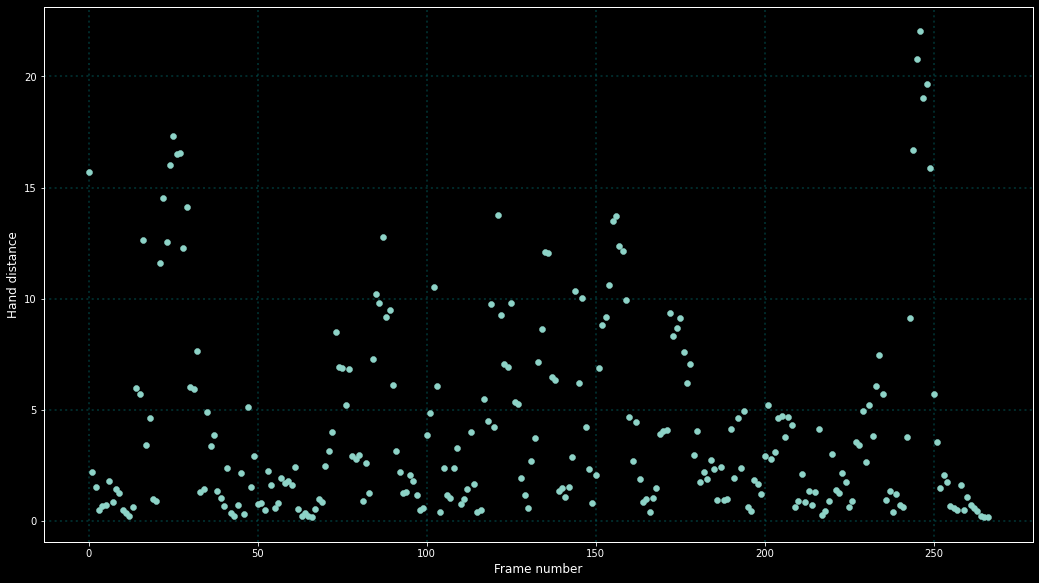

In [140]:
plt.grid(visible=True, color="DarkTurquoise", alpha=0.2, linestyle=":", linewidth=2)
plt.rcParams["figure.figsize"] = [45 / 2.54, 25 / 2.54]

plt.scatter([i for i in range(0, initial_no_frames - 1)], hand_distance)

plt.ylabel("Hand distance")
plt.xlabel("Frame number")
plt.show()


Plotting a threshold that accepts frames that contain less than 10% hand movement compared to the maximum hand movement

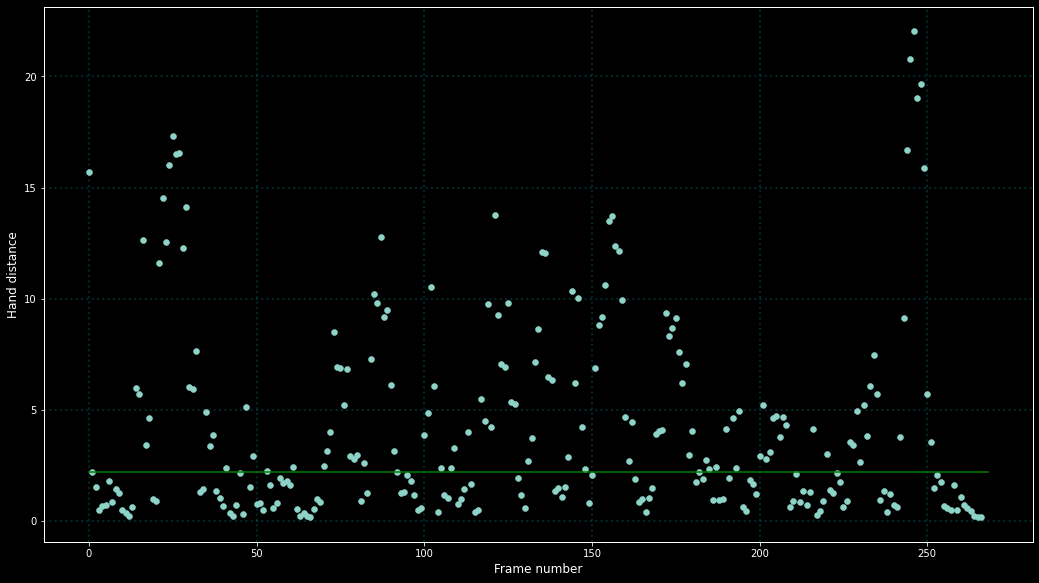

In [141]:
plt.grid(visible=True, color="DarkTurquoise", alpha=0.2, linestyle=":", linewidth=2)
plt.rcParams["figure.figsize"] = [45 / 2.54, 25 / 2.54]

plt.scatter([i for i in range(0, initial_no_frames - 1)], hand_distance)
alpha = round(0.1 * max(hand_distance), 2)
plt.plot([0, initial_no_frames], [alpha, alpha], color="green")

plt.ylabel("Hand distance")
plt.xlabel("Frame number")
plt.show()


## Finding a threshold for hand height

Plotting the hand height for each frame in the video file to see how the value changes.

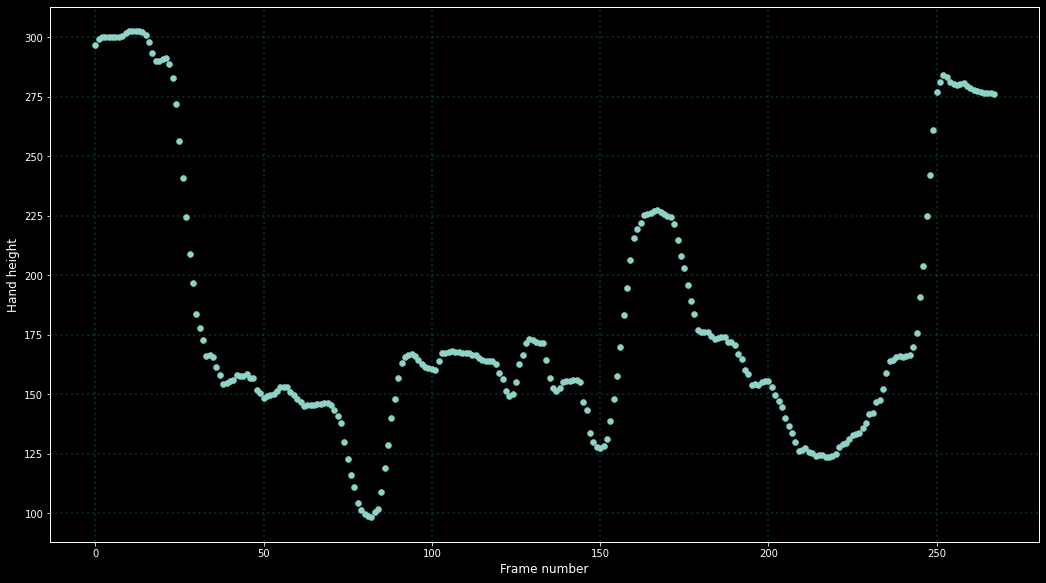

In [142]:
plt.grid(visible=True, color="DarkTurquoise", alpha=0.2, linestyle=":", linewidth=2)
plt.rcParams["figure.figsize"] = [45 / 2.54, 25 / 2.54]

plt.scatter([i for i in range(0, initial_no_frames)], hand_height)
plt.ylabel("Hand height")
plt.xlabel("Frame number")
plt.show()


Calculating a list of the absolute change in hand height between current fame and previous frame to visualize how change in hand height varies over the course of the video.

In [143]:
hand_height_delta = []
for i in range(len(hand_height) - 1):
    hand_height_delta.append(abs(round(hand_height[i] - hand_height[i + 1], 2)))
print((hand_height_delta))
print(len(hand_height))


[2.85, 0.51, 0.08, 0.04, 0.04, 0.0, 0.35, 0.48, 0.99, 0.87, 0.02, 0.03, 0.12, 0.14, 1.34, 2.86, 4.81, 3.41, 0.17, 0.82, 0.49, 2.47, 6.01, 10.77, 15.46, 15.71, 16.29, 15.73, 12.25, 12.84, 5.98, 4.88, 6.66, 0.3, 0.77, 4.27, 3.26, 3.78, 0.19, 0.93, 0.58, 1.77, 0.09, 0.23, 0.72, 1.67, 0.0, 4.99, 1.24, 2.05, 0.76, 0.64, 0.45, 1.19, 1.43, 0.05, 0.05, 1.95, 1.43, 1.43, 1.46, 1.7, 0.34, 0.15, 0.03, 0.24, 0.17, 0.36, 0.06, 0.74, 2.23, 2.43, 2.89, 8.12, 6.93, 6.87, 5.14, 6.76, 2.71, 1.9, 0.87, 0.49, 2.51, 1.26, 6.98, 10.14, 9.73, 11.31, 7.89, 8.93, 6.0, 2.57, 1.05, 0.22, 0.58, 1.95, 1.71, 1.09, 0.42, 0.58, 0.27, 3.88, 3.33, 0.02, 0.09, 0.56, 0.21, 0.25, 0.16, 0.07, 0.11, 0.87, 0.24, 1.25, 0.79, 0.42, 0.05, 0.11, 0.9, 3.78, 2.67, 5.01, 2.22, 1.02, 5.05, 7.26, 3.86, 4.91, 1.89, 0.62, 0.55, 0.31, 0.25, 7.17, 7.35, 4.32, 1.47, 1.39, 2.53, 0.36, 0.07, 0.37, 0.07, 0.92, 8.35, 3.46, 9.56, 3.75, 2.15, 0.46, 1.03, 2.89, 7.57, 9.16, 9.56, 12.49, 13.24, 11.52, 11.65, 9.15, 3.66, 2.53, 3.54, 0.51, 0.38, 0.9

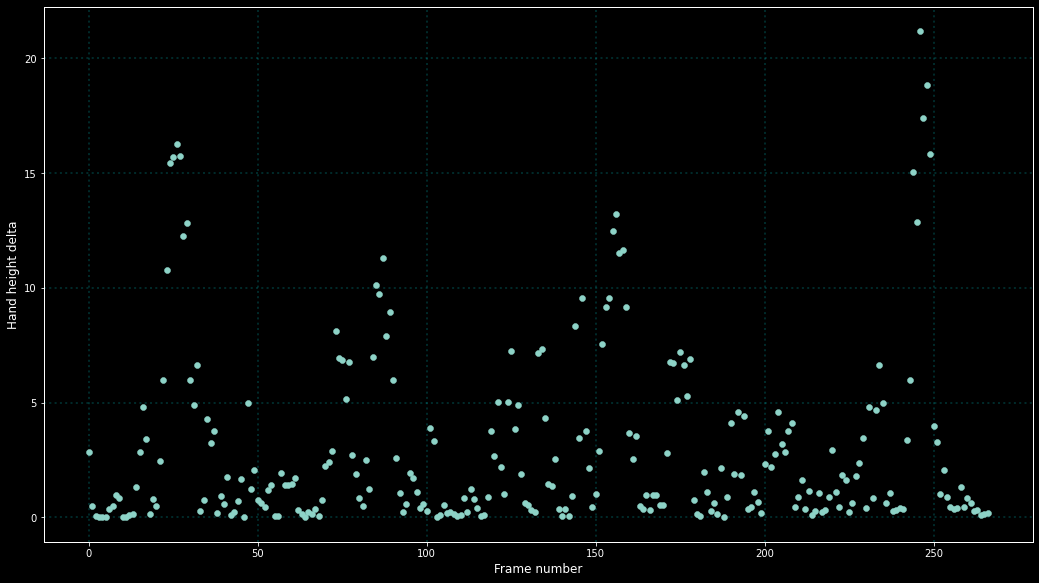

In [144]:
plt.grid(visible=True, color="DarkTurquoise", alpha=0.2, linestyle=":", linewidth=2)
plt.rcParams["figure.figsize"] = [45 / 2.54, 25 / 2.54]

plt.scatter([i for i in range(0, initial_no_frames - 1)], hand_height_delta)

plt.ylabel("Hand height delta")
plt.xlabel("Frame number")
plt.show()


We can notice that the outliers in this graph lies at the beginnning and end of the video. These parts correspond to when there is maximum change in the hand height during the video. So I split the data into two halves and take the maximum value of each half. Then plot these values on the above graph.

In [145]:
hand_height_delta_one = hand_height_delta[: len(hand_height_delta) // 2]
hand_height_delta_two = hand_height_delta[len(hand_height_delta) // 2 :]

beta1_idx = hand_height_delta_one.index(max(hand_height_delta_one))
beta2_idx = hand_height_delta_two.index(max(hand_height_delta_two)) + len(
    hand_height_delta_one
)


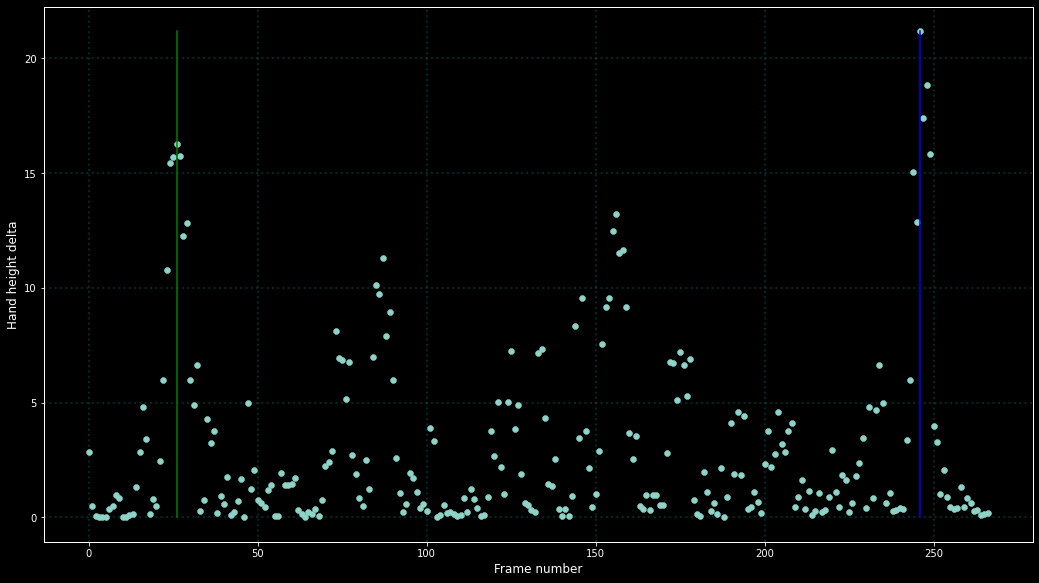

In [146]:
plt.grid(visible=True, color="DarkTurquoise", alpha=0.2, linestyle=":", linewidth=2)
plt.rcParams["figure.figsize"] = [45 / 2.54, 25 / 2.54]

plt.scatter([i for i in range(0, initial_no_frames - 1)], hand_height_delta)

plt.plot([beta1_idx, beta1_idx], [max(hand_height_delta), 0], color="green")
plt.plot([beta2_idx, beta2_idx], [max(hand_height_delta), 0], color="blue")

plt.ylabel("Hand height delta")
plt.xlabel("Frame number")
plt.show()


Now plotting these values on the original hand height data, to verify that we found a good adaptive threshold

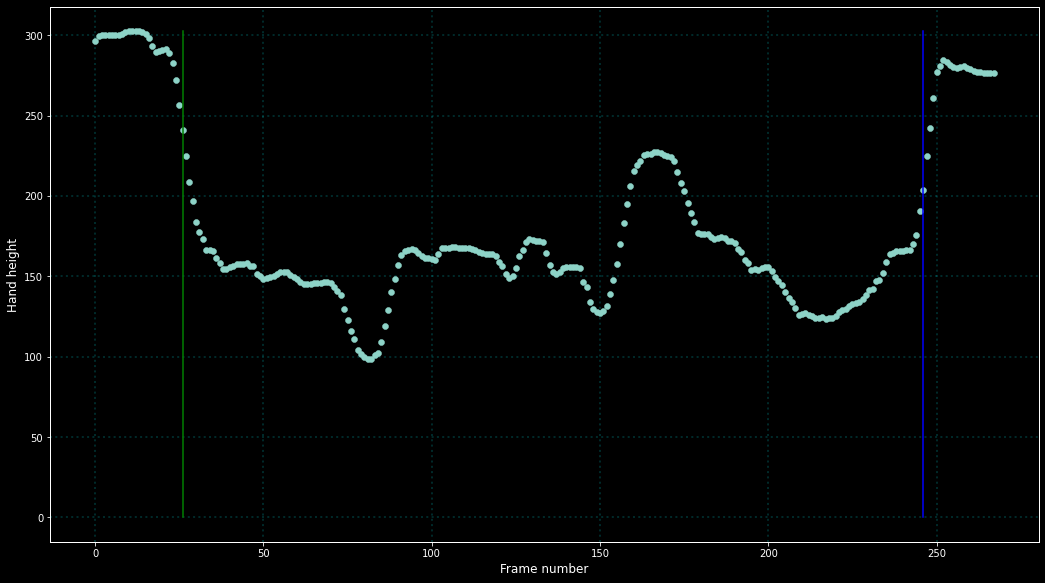

In [147]:
plt.grid(visible=True, color="DarkTurquoise", alpha=0.2, linestyle=":", linewidth=2)
plt.rcParams["figure.figsize"] = [45 / 2.54, 25 / 2.54]

plt.scatter([i for i in range(0, initial_no_frames)], hand_height)

plt.plot([beta1_idx, beta1_idx], [max(hand_height), 0], color="green")
plt.plot([beta2_idx, beta2_idx], [max(hand_height), 0], color="blue")

plt.ylabel("Hand height")
plt.xlabel("Frame number")
plt.show()


Using the computed thresholds to output the processed video file, which will not include frames that are not passing the threshold values

In [148]:
video = cv2.VideoCapture(data_path)
output_path = os.path.join("../output/", vid_file_name.split(".")[0] + "_output.mp4")
fourcc = cv2.VideoWriter_fourcc("m", "p", "4", "v")
dim = (
    int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    int(video.get(cv2.CAP_PROP_FRAME_WIDTH)),
)
output = cv2.VideoWriter(output_path, fourcc, video.get(cv2.CAP_PROP_FPS), dim)

frame_num = 0
output_frames = 0
while True:
    ret, frame = video.read()
    if not ret:
        break
    if (
        hand_distance[frame_num - 1] > alpha
        and frame_num != 0
        and frame_num > beta1_idx
        and frame_num < beta2_idx
    ):
        output.write(frame)
        output_frames += 1
    frame_num += 1
output.release()


Creating video summary dictionary to store the video metadata

In [149]:
video_summary = {}
video_summary["Filename"] = vid_file_name
video_summary["Hand_Height"] = hand_height
video_summary["Hand_Distance"] = hand_distance
video_summary["Initial_Frame_Count"] = initial_no_frames
video_summary["Post_KFS_Frame_Count"] = output_frames
video_summary["Percentage_Reduction"] = round(
    ((initial_no_frames - output_frames) / initial_no_frames) * 100, 2
)
video_summary["Hand_Height_Threshold_Value"] = [beta1_idx, beta2_idx]
video_summary["Hand_Distance_Threshold_Value"] = alpha

output_path = os.path.join("../output/", vid_file_name.split(".")[0] + "_output.json")

with open(output_path, "w") as f:
    f.write(json.dumps(video_summary))

for detail in video_summary:
    print(f"{detail}: {video_summary[detail]}")


Filename: sample6.mp4
Hand_Height: [296.64, 299.49, 300.0, 299.92, 299.96, 299.92, 299.92, 300.27, 300.75, 301.74, 302.61, 302.59, 302.56, 302.44, 302.3, 300.96, 298.1, 293.29, 289.88, 290.05, 290.87, 291.36, 288.89, 282.88, 272.11, 256.65, 240.94, 224.65, 208.92, 196.67, 183.83, 177.85, 172.97, 166.31, 166.61, 165.84, 161.57, 158.31, 154.53, 154.72, 155.65, 156.23, 158.0, 157.91, 157.68, 158.4, 156.73, 156.73, 151.74, 150.5, 148.45, 149.21, 149.85, 150.3, 151.49, 152.92, 152.97, 153.02, 151.07, 149.64, 148.21, 146.75, 145.05, 145.39, 145.54, 145.57, 145.81, 145.98, 146.34, 146.4, 145.66, 143.43, 141.0, 138.11, 129.99, 123.06, 116.19, 111.05, 104.29, 101.58, 99.68, 98.81, 98.32, 100.83, 102.09, 109.07, 119.21, 128.94, 140.25, 148.14, 157.07, 163.07, 165.64, 166.69, 166.91, 166.33, 164.38, 162.67, 161.58, 161.16, 160.58, 160.31, 164.19, 167.52, 167.54, 167.63, 168.19, 167.98, 167.73, 167.57, 167.5, 167.61, 166.74, 166.5, 165.25, 164.46, 164.04, 163.99, 163.88, 162.98, 159.2, 156.53, 151

## Insights and Summary


**My approach**

Two parameters were calculated and keyframe selection was done using them. In this task, I used 2 methods to automatically calculate a threshold for any particular video.

For the hand distance, the frames between which the hand distances were small, are very similar and do not contribute anything of value. These values needed to be removed. On plotting the hand distance vs no. of frame graph, it was clear that we could remove most of the lower values. I removed the unwanted frames by taking a threshold of 10% of the maximum hand distance.

For the hand height, on plotting it, it was clear that there were periods during the beginning and ending part of the video where the hand height changes quickly, So I calculated the difference of hand height between frames. On visualizing this data, a clear trend emerged where there were two outliers, one at the beginning part, and another one at the ending part of the video. I used this trend to get two thresholds, which were frame numbers of the video. The data we needed would be in between these frame numbers.

In [150]:
summary_data = []
for filename in sorted(os.listdir("../output")):
    filepath = os.path.join("../output", filename)
    if os.path.isfile(filepath) and os.path.splitext(filepath)[1] == ".json":
        with open(filepath) as f:
            data = json.load(f)
        summary_data.append(data)
        print(
            f"============== Summary of {os.path.splitext(os.path.basename(filename))[0].split('_')[0]}.mp4 =============="
        )
        print(f"Initial Frame Count: {data['Initial_Frame_Count']}")
        print(f"Post KFS Frame Count: {data['Post_KFS_Frame_Count']}")
        print(f"Percentage Reduction: {data['Percentage_Reduction']}%")


============== Summary of sample1.mp4 ==============
Initial Frame Count: 262
Post KFS Frame Count: 40
Percentage Reduction: 84.73%
============== Summary of sample2.mp4 ==============
Initial Frame Count: 155
Post KFS Frame Count: 32
Percentage Reduction: 79.35%
============== Summary of sample3.mp4 ==============
Initial Frame Count: 251
Post KFS Frame Count: 68
Percentage Reduction: 72.91%
============== Summary of sample4.mp4 ==============
Initial Frame Count: 187
Post KFS Frame Count: 29
Percentage Reduction: 84.49%
============== Summary of sample5.mp4 ==============
Initial Frame Count: 226
Post KFS Frame Count: 76
Percentage Reduction: 66.37%
============== Summary of sample6.mp4 ==============
Initial Frame Count: 268
Post KFS Frame Count: 124
Percentage Reduction: 53.73%


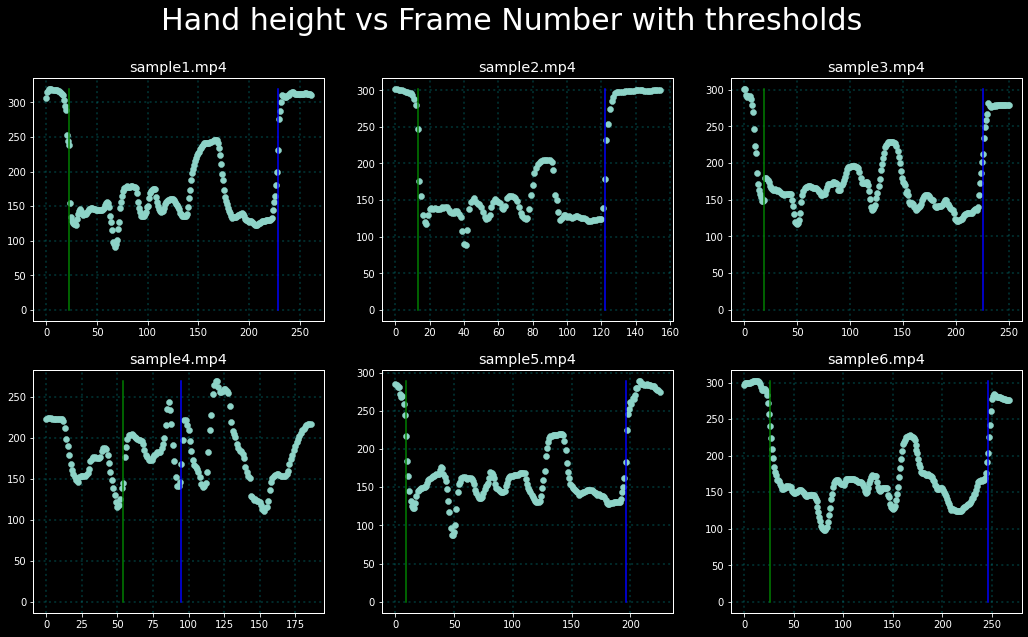

In [151]:
plt.rcParams["figure.figsize"] = [45 / 2.54, 25 / 2.54]

figure, axis = plt.subplots(2, 3)
figure.suptitle("Hand height vs Frame Number with thresholds", size=30)
count = 0
row = 0
for data in summary_data:
    if count > 2:
        row = 1
    axis[row, count % 3].set_title(f'{data["Filename"]}')
    axis[row, count % 3].grid(
        visible=True, color="DarkTurquoise", alpha=0.2, linestyle=":", linewidth=2
    )
    axis[row, count % 3].scatter(
        [i for i in range(0, data["Initial_Frame_Count"])], data["Hand_Height"]
    )

    axis[row, count % 3].plot(
        [
            data["Hand_Height_Threshold_Value"][0],
            data["Hand_Height_Threshold_Value"][0],
        ],
        [max(data["Hand_Height"]), 0],
        color="green",
    )
    axis[row, count % 3].plot(
        [
            data["Hand_Height_Threshold_Value"][1],
            data["Hand_Height_Threshold_Value"][1],
        ],
        [max(data["Hand_Height"]), 0],
        color="blue",
    )
    count += 1


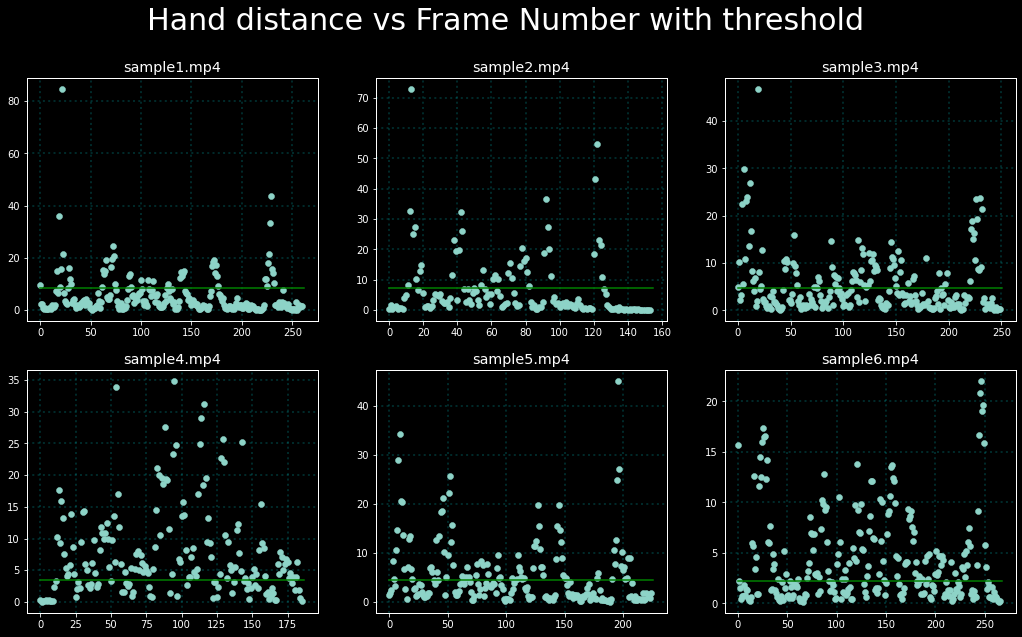

In [152]:
plt.rcParams["figure.figsize"] = [45 / 2.54, 25 / 2.54]

figure, axis = plt.subplots(2, 3)
figure.suptitle("Hand distance vs Frame Number with threshold", size=30)
count = 0
row = 0
for data in summary_data:
    if count > 2:
        row = 1
    axis[row, count % 3].set_title(f'{data["Filename"]}')
    axis[row, count % 3].grid(
        visible=True, color="DarkTurquoise", alpha=0.2, linestyle=":", linewidth=2
    )
    axis[row, count % 3].scatter(
        [i for i in range(0, data["Initial_Frame_Count"] - 1)], data["Hand_Distance"]
    )
    alpha = round(0.1 * max(data["Hand_Distance"]), 2)

    axis[row, count % 3].plot(
        [0, data["Initial_Frame_Count"]], [alpha, alpha], color="green"
    )
    count += 1


**Inferences**

The method to select key frames based on hand height does a good job at approximating the correct frames for most videos. The method gives poor results in videos where the hand height does not change from the beginning and end parts to the height at which the signing is done. In sample4.mp4, this is what happens. Since there is no significant height difference from the beginning, the threshold is detected during the signing process.

* Advantages:
    - Accurate detection of key frames for most videos.
* Disadvantages:
    - Threshold values cannot be fine tuned unlike the threshold for hand distance.

A possible solution could be to add a bias to prefer frame numbers towards the beginning and end of the videos.